In [ ]:
# read in patient key
root = UF.DataRoot(2)
LimbusKey = pd.read_csv(root + "\\Aaron\\ProstateMRL\\Code\\Extraction\\PatKeys\\LimbusKey.csv")
AllKey = pd.read_csv(root + "\\Aaron\\ProstateMRL\\Code\\Extraction\\PatKeys\\AllPatientKey_s.csv")

# Loop through treatments
treatments = AllKey["Treatment"].unique()
new_key = pd.DataFrame()
for t in treatments:
    AllKey_t = AllKey[AllKey["Treatment"] == t]
    LimbusKey_t = LimbusKey[LimbusKey["Treatment"] == t]

    # Loop through patients
    patIDs = LimbusKey_t["PatID"].unique()

    for pat in patIDs:
        pat_L = LimbusKey_t[LimbusKey_t["PatID"] == pat]
        pat_A = AllKey_t[AllKey_t["PatID"] == pat]
        print(pat_A)
        print(pat_L)
        # add date and days column from all to limbus key based on Scan
        for i in range(len(pat_L)):
            scan = pat_L.iloc[i]["Scan"]
            fraction = pat_A.iloc[i]["Fraction"]
            date = pat_A[pat_A["Scan"] == scan]["Date"].values[0]
            days = pat_A[pat_A["Scan"] == scan]["Days"].values[0]
            pat_L.at[pat_L.index[i], "Date"] = str(date)
            pat_L.at[pat_L.index[i], "Days"] = int(days)
            pat_L.at[pat_L.index[i], "Fraction"] = int(fraction)

        pat_L["Days"] = pat_L["Days"].astype(int)
        # sort by days
        pat_L = pat_L.sort_values(by=["Fraction"])

    # add to new key
        new_key = new_key.append(pat_L)

new_key.to_csv(root + "\\Aaron\\ProstateMRL\\Code\\Extraction\\PatKeys\\LimbusKey_s.csv", index=False)


        
        



In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

csvs = os.listdir("E:\\Aaron\ProstateMRL\Data\Paper1\HM-FSTP\\Longitudinal\ClusterLabels\\")
#csvs = [csv for csv in csvs if "HM" in csv]

fts_s = pd.read_csv("E:\\Aaron\ProstateMRL\Data\Paper1\\HM-FSTP\\Features\\SelectedFeatures_Longitudinal.csv")
fts_s = fts_s["Feature"].values
for csv in csvs:
    df = pd.read_csv("E:\\Aaron\ProstateMRL\Data\Paper1\\HM-FSTP\\Longitudinal\ClusterLabels\\" + csv)
    pat = str(csv)[:-4]
    df["Selected"] = df["Feature"].apply(lambda x: x in fts_s)
    # print where selected is True
    df = df[['Feature', 'Cluster', 'Fraction', 'FeatureChange', 'Selected']]
    df['Feature'] = df['Feature'].str.replace('original_', '')
    clusters = df["Cluster"].unique()
    clusters = sorted(clusters, key=lambda x: int(x))
    for c in clusters:
        df_c = df[df["Cluster"] == c]
        df_c = df_c.sort_values(by = ["Fraction"])

        # get selected features
        selected_fts = df_c[df_c["Selected"] == True]["Feature"].unique()
        if len(selected_fts) == 0:
            sf_str = "No features selected"
        
        number_fts = "Total number of feature(s) in Cluster {}: {}\nNumber of selected features: {}\n".format(c, df_c["Feature"].nunique(), len(selected_fts) )
        text_str = selected_fts
        text_str = '\n'.join(text_str)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        fts = df_c["Feature"].values
        plt.figure(figsize=(10, 10))
        plt.title(" Cluster " + str(c))
        sns.set_theme(style="whitegrid")
        sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
        for ft in fts:
            df_ft = df_c[df_c["Feature"] == ft]
            values = df_ft["FeatureChange"].values
            fractions = df_ft["Fraction"].values
            colour = "blue" if df_ft["Selected"].values[0] else "grey"
            l = df_ft["Feature"].values[0]
            plt.plot(fractions, values, label = l, color = colour)
            #plt.scatter(fractions, values, color = colour)
        plt.xlabel("Fraction", fontsize = 20)
        plt.ylabel("Feature Change", fontsize = 20)
        plt.xticks(np.arange(1, 5.1, 1))
        plt.xlim(1, 5)
        #plt.ylim(-1, 1)
        # add text box
        #plt.text(0.05, 0.95, (number_fts + text_str), transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=props)
        
        #plt.legend(title = "Feature Selected", bbox_to_anchor=(1, 0.6), labels = ["Yes", "No"])
        plt.title("Cluster " + str(c), fontsize = 30)
        plt.savefig("E:\\Aaron\ProstateMRL\Data\Paper1\HM-FSTP\Longitudinal\ClusterPlots\\Run2_" + str(pat) + "_Cluster" + str(c) + ".png", bbox_inches = "tight")
        #plt.show()
        plt.close()






In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

dir = "E:\\Aaron\\ProstateMRL\\Data\\Paper1\\NormSummary\\"

files = os.listdir(dir)

result = pd.DataFrame()

for file in files:
    # loop through txt files and get lines that contain Before:
    with open(dir + file, "r") as f:
        lines = f.readlines()
        # filter so only lines with Before: are kept
        # get line with 
        lines = [line for line in lines if "Longitudinal" in line]

        r_lines = [line for line in lines if "Removed:" in line]
        s_line = [line for line in lines if "Selected:" in line]
        
        ICC = int(r_lines[0][-3:])
        Vol = int(r_lines[1][-3:])
        Sel = int(s_line[0][-3:])

        result = result.append({"Norm": file[:-4], "ICC": ICC, "Volume": Vol, "Selected": Sel}, ignore_index=True) 
result = result.melt(id_vars=["Norm"], var_name="Stage", value_name="Number")

# order result so plot is in correct order
result["Norm"] = pd.Categorical(result["Norm"], ["Raw", "HM-FS", "HM-TP", "HM-FSTP", "Med-Pros", "Med-Psoas"])
result["Stage"] = pd.Categorical(result["Stage"], ["ICC", "Volume", "Selected"])

# bar plot results
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x="Norm", y="Number", data=result, hue="Stage")
plt.xlabel("Normalisation", fontsize = 20)
plt.ylabel("Number of Features", fontsize = 20)
plt.title("Number of Features Removed or Selected", fontsize = 26)



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("E:\\Aaron\ProstateMRL\Code\PatKeys\\MedianSignalNorm.csv")
df = df.drop(columns=["Unnamed: 0"])

# pick a random patient
pat = df["PatID"].sample().values[0]

# change Mask variables to Prostate and Psoas
df["Mask"] = df["Mask"].apply(lambda x: "Prostate" if x == "shrunk_pros" else "Psoas")
df = df[df["PatID"] == pat]
# plot signal over time for each normalisation in facet grid
g = sns.FacetGrid(df, col="Norm", hue="Mask", col_wrap=3, height=5, aspect=1.5)
g.map(sns.lineplot, "Scan", "Median", marker="o")
g.set_axis_labels("Fraction", "Median Signal")
g.set_titles("{col_name}")
g.add_legend()
plt.suptitle("Median Signal for Patient " + str(pat), fontsize = 30)
plt.subplots_adjust(top=0.9)
plt.show()



In [ ]:
import pandas as pd
from sklearn import preprocessing
from tqdm import tqdm
root = "E:\\"
Norm = "HM-FS"

#df_all = pd.read_csv(root + "Aaron\ProstateMRL\Data\Paper1\\" + Norm + "\\Features\\Longitudinal_All_fts_Baseline.csv")
# remove minimum feature
df_all = pd.read_csv(root + "Aaron\ProstateMRL\Data\Paper1\\" + Norm + "\\Features\\Longitudinal_Limbus_fts_Baseline.csv")
df_all = df_all[df_all["Feature"] != "original_firstorder_Minimum"]


df_res = pd.DataFrame()
for ft in tqdm(df_all["Feature"].unique()):
    df_ft = df_all[df_all["Feature"] == ft]
    ft_vals = df_ft["FeatureValue"].values
    ft_change = df_ft["FeatureChange"].values
    
    ft_vals01 = preprocessing.minmax_scale(ft_vals, feature_range=(0, 1))
    ft_change01 = preprocessing.minmax_scale(ft_change, feature_range=(0, 1))
    
    df_ft.loc[df_all["Feature"] == ft, "FeatureValue"] = ft_vals01
    df_ft.loc[df_all["Feature"] == ft, "FeatureChange"] = ft_change01
    # append 
    df_res = df_res.append(df_ft, ignore_index=True)

df_res.to_csv(root + "Aaron\ProstateMRL\Data\Paper1\\" + Norm + "\\Features\\Longitudinal_Limbus_fts_BaselineRS.csv")

    

# pivot table so feature values and changes are in columns
# plot features over time for each patient in facet grid


    

In [ ]:
# pivot df long 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df_l = df_all.melt(id_vars=["PatID", "Scan", "Mask", "Fraction", "Days", "Feature"], var_name="FeatureType", value_name="Value")

df_l = df_l[df_l["FeatureType"].isin(["FeatureRS11", "FeatureRS01", "FeatureChangeRS11", "FeatureChangeRS01"])]
# add small random noise to fraction to avoid overlapping points
df_l["Fraction"] = df_l["Fraction"] + np.random.normal(0, 0.05, df_l.shape[0])

# plot features over time for each patient in facet grid
for ft in df_l["Feature"].unique()[0:10]:
    df_l_ft = df_l[df_l["Feature"] == ft]
    g = sns.FacetGrid(df_l_ft, col="PatID", hue="FeatureType", col_wrap=5, height=5, aspect=1.5)
    g.map(sns.lineplot, "Fraction", "Value", marker="o")
    g.set_axis_labels("Fraction", "Feature Value")
    g.set_titles("{col_name}")
    g.add_legend()
    plt.suptitle(ft, fontsize = 30)
    plt.subplots_adjust(top=0.9)
    plt.show()
    plt.close()



In [ ]:
import pandas as pd


def ClusterCount(root, Norm, output, tag):
    '''
    Summarises clustering results
    '''
    patIDs = ['653', '713', '752', '826', '1088', '1089', '1118', '1303', '1307', '1464', '1029',
    '1302', '1431', '1481', '1540', '1553', '1601', '1642', '829', '955']
    dir = root + "\\Aaron\\ProstateMRL\\Data\\Paper1\\" + Norm + "\\Longitudinal\\ClusterLabels\\"
    #patIDs = UF.SABRPats()
    df_result = pd.DataFrame()

    for pat in patIDs:

        df = pd.read_csv(root + "\\Aaron\\ProstateMRL\\Data\\Paper1\\" + Norm + "\\Longitudinal\\ClusterLabels\\" + pat + "_" + tag + ".csv")
        df = df[["Feature", "Cluster"]]
        df = df.drop_duplicates()
        # sort by cluster
        df = df.sort_values(by=["Cluster"])
        # turn value counts into a dataframe
        df = df["Cluster"].value_counts().rename_axis("Cluster").reset_index(name="Counts")
        # set PatID as index
        df["PatID"] = pat
        # set PatID as index
        df.set_index("PatID", inplace=True)
            
        # append to result
        df_result = df_result.append(df, ignore_index=False)
    
    
    
    # get number of clusters per patient
    df_numclust= df_result.groupby("PatID")["Cluster"].count()
    
    # get number of clusters with more than 3 features
    df_stable = df_result[df_result["Counts"] > 3]
    df_stable = df_stable.groupby("PatID")["Cluster"].count()
    
    # merge number of clusters with more than 3 features and number of clusters
    df_numclust = df_numclust.rename_axis("PatID").reset_index(name="NumClusters")
    df_stable = df_stable.rename_axis("PatID").reset_index(name="NumStableClusters")
    df_numclust = pd.merge(df_numclust, df_stable, on="PatID")
    # get mean number of clusters
    meanclust = df_numclust["NumClusters"].mean()
    # get mean number of stable clusters
    meanstable = df_numclust["NumStableClusters"].mean()
    # get mean number of features per cluster
    df_numfts = df_result.groupby("PatID")["Counts"].mean()
    df_numfts = df_numfts.rename_axis("PatID").reset_index(name="MeanFeaturesperCluster")
    df_numclust = pd.merge(df_numclust, df_numfts, on="PatID")
    # get mean number of features per stable cluster
    df_numfts = df_result[df_result["Counts"] > 3]
    df_numfts = df_numfts.groupby("PatID")["Counts"].mean()
    df_numfts = df_numfts.rename_axis("PatID").reset_index(name="MeanFeaturesperStableCluster")
    df_numclust = pd.merge(df_numclust, df_numfts, on="PatID")

    
    print("Mean number of clusters: " + str(meanclust))
    print("Mean number of stable clusters: " + str(meanstable))
    print("Mean number of features per cluster: " + str(df_numclust["MeanFeaturesperCluster"].mean()))
    print("Mean number of features per stable cluster: " + str(df_numclust["MeanFeaturesperStableCluster"].mean()))


In [ ]:
root = "E:\\"
Norm = "HM-FS"
output = False
tag = "Baseline"
ClusterCount(root, Norm, output, tag)

In [ ]:
root = "E:\\"
Norm = "HM-FS"
output = False
tag = "BaselineRS"
ClusterCount(root, Norm, output, tag)

In [ ]:
root = "E:\\"
Norm = "HM-FS"
output = False
tag = "t_val_15"
ClusterCount(root, Norm, output, tag)

In [ ]:
import pandas as pd

df = pd.read_csv("E:\\Aaron\\ProstateMRL\\Data\\Paper1\\HM-FS\\Features\\Longitudinal_All_fts_Baseline.csv")
ok_pats = df.loc[df["Fraction"] == 5]["PatID"].unique()
# need_pats = df.loc[df["Fraction"] == 0]["PatID"].unique()
print(ok_pats)
need_pats = []
#need_pats = [x for x in need_pats if x not in ok_pats]
#print(need_pats)

for pat in df["PatID"].unique():
    tps = len(df.loc[df["PatID"] == pat]["Fraction"].unique())
    Scans = df.loc[df["PatID"] == pat]["Scan"].unique()
    if tps < 5:
        print("Pat: {} Timepoints: {}, Scans: {}".format(pat, tps, Scans))
        need_pats.append(pat)
print(need_pats)


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import UsefulFunctions as UF
Norms = UF.NormArray()

root = "E:\\"

# loop through norms and get number of features removed / selected
df = pd.DataFrame(columns = ["Norm", "Stage", "Features"])
for Norm in Norms:
    fts_s = pd.read_csv(root + "Aaron\ProstateMRL\Data\Paper1\\OldFeatureFiles\\" + Norm + "\\Longitudinal_SelectedFeatures.csv")
    fts_s = fts_s["Feature"].values
    fts_vol = pd.read_csv(root + "Aaron\ProstateMRL\Data\Paper1\\OldFeatureFiles\\" + Norm + "\\Longitudinal_FeaturesRemoved_Volume.csv")
    fts_vol = fts_vol["Feature"].values
    fts_icc = pd.read_csv(root + "Aaron\ProstateMRL\Data\Paper1\\OldFeatureFiles\\" + Norm + "\\Longitudinal_FeaturesRemoved_ICC.csv")
    fts_icc = fts_icc["Feature"].values
    df = df.append({"Norm": Norm, "Stage": "Volume", "Features": len(fts_vol)}, ignore_index = True)
    df = df.append({"Norm": Norm, "Stage": "ICC", "Features": len(fts_icc)}, ignore_index = True)
    df = df.append({"Norm": Norm, "Stage": "Selected", "Features": len(fts_s)}, ignore_index = True)

# plot
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 10))
sns.barplot(x="Norm", y="Features", hue="Stage", data=df)
#plt.title("Number of Features Removed / Selected", fontsize = 30)
plt.xlabel("Normalisation", fontsize = 20)
plt.ylabel("Number of Features", fontsize = 20)
plt.show()

In [ ]:
df1 = pd.read_csv("C:\\Users\\b01297ar\\Documents\ProstateMRL-local\ProstateMRL-Radiomics\Paper1-Code\PatKeys\MedianSignalNorms.csv")
df2 = pd.read_csv("C:\\Users\\b01297ar\\Documents\ProstateMRL-local\ProstateMRL-Radiomics\Paper1-Code\PatKeys\MedianSignalMG.csv")

df1 = df1.append(df2, ignore_index = True)

df1.to_csv("C:\\Users\\b01297ar\\Documents\ProstateMRL-local\ProstateMRL-Radiomics\Paper1-Code\PatKeys\MedianSignal3.csv", index = False)

In [ ]:
import pandas as pd
import numpy as np
import UsefulFunctions as UF
import seaborn as sns
import matplotlib.pyplot as plt

root = "E:\\"

# get MedianSignalNorms.csv and plot median signal intensity for pat 1540 for different normalisations in facetgrid

Norms = UF.NormArray()
# remove Raw from Norms
Norms = Norms[1:]
df = pd.read_csv("C:\\Users\\b01297ar\\Documents\ProstateMRL-local\ProstateMRL-Radiomics\Paper1-Code\PatKeys\MedianSignal3.csv")
# get all norms except Raw
df = df.loc[df["Norm"].isin(Norms)]

#df = pd.DataFrame(columns = ["Norm", "PatID", "Scan", "Mask", "Median"])
df = df.loc[df["PatID"] == 1540]


# facetgrid
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(df, col="Norm", hue="Mask", col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, "Scan", "Median", marker="o", legend=False)
g.set_axis_labels("Scan", "Median Signal Intensity")
# change the title of each facet

g.set_titles("{col_name}", size=20)
# dont show the legend
plt.show()





In [ ]:
raw_df = pd.read_csv("C:\\Users\\b01297ar\\Documents\ProstateMRL-local\ProstateMRL-Radiomics\Paper1-Code\PatKeys\MedianSignalRaw.csv")
raw_df = raw_df.loc[raw_df["PatID"] == 1540]

# plot
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
sns.lineplot(x="Scan", y="Median", hue="Mask", data=raw_df, marker="o", legend=False)
sns.scatterplot(x="Scan", y="Median", hue="Mask", data=raw_df, marker="o")
plt.title("Raw", fontsize = 30)
plt.xlabel("Scan", fontsize = 20)
plt.ylabel("Median Signal Intensity", fontsize = 20)
# change legend labels
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Prostate", "Psoas", "Glute"]
# make legend outside plot
plt.legend(handles, labels, bbox_to_anchor=(1.05, 0.6), fontsize = "20" ,loc=2, borderaxespad=0.)


#plt.legend(handles, labels)

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import UsefulFunctions as UF
import seaborn as sns
import matplotlib.pyplot as plt
import os

root = "C:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\Data\\Ttest\\"

files = os.listdir(root + "Tries\\")
df_all = pd.DataFrame()

for f in files:
    df_t = pd.read_csv(root + "Tries\\" + f)
    # drop first column
    #df_t = df_t.drop(df.columns[0], axis=1)
    df_all = df_all.append(df_t, ignore_index = True)


df_all = df_all.drop(df_all.columns[0], axis=1)


In [ ]:
# get average number of tries for each startTval
df_avg_mn = df_all.groupby("StartTval").mean()
df_avg_sd = df_all.groupby("StartTval").std()
# only keep the number of tries column
#df_avg.set_index("StartTval", inplace = True)
df_avg_mn = df_avg_mn["Tries"]
df_avg_sd = df_avg_sd["Tries"]
df_avg = pd.DataFrame()
df_avg["Mean"] = df_avg_mn
df_avg["Sd"] = df_avg_sd
df_avg.index.name = "StartTval"
#print(df_avg)

# plot
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
sns.lineplot(x=df_avg.index, y=df_avg.Mean, marker="o", color = "blue", legend=False)
sns.lineplot(x=df_avg.index, y=df_avg.Sd, marker="o", color = "red", legend=False)
plt.xlabel("Start Tval", fontsize = 20)
plt.xticks(np.arange(1, 3.01, step=0.25))
plt.ylabel("Attempts", fontsize = 20)
plt.legend(["Mean", "Sd"], fontsize = "20")
plt.title("Number of attempts to cluster", fontsize = 30)
plt.show()



In [ ]:


# t-vals to colours for plotting
tvals = np.arange(1, 3.01, step=0.25)
colours = sns.color_palette("colorblind", len(tvals))

df_plot = df_all.copy()

# violin plot
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
sns.violinplot(x="StartTval", y="Tries", hue="StartTval", palette=colours, data=df_plot)
plt.xlabel("Start Tval", fontsize = 20)
#plt.xticks(np.arange(1, 3.01, step=0.25))
plt.ylabel("Attempts", fontsize = 20)
#plt.legend(fontsize = "16", title = "Start Tval", title_fontsize = "20", loc = "upper right")
plt.title("Number of attempts to cluster", fontsize = 30)
plt.show()



In [ ]:
df_plot2 = df_all.copy()

# groupy by startTval and patID and get mean
df_plot2 = df_plot2.groupby(["StartTval", "PatID"]).mean()
df_plot2 = df_plot2.reset_index()
#df_plot2 = df_plot2.drop(df_plot2.columns[0], axis=1)
#df_plot2.columns = ["StartTval", "PatID", "Tries"]
print(df_plot2["StartTval"].unique())
df_plot2["StartTval"] = df_plot2["StartTval"].astype(float)
# violin plot
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x="StartTval", y="Tries", hue="StartTval", palette=colours, data=df_plot2)

plt.legend().remove()
plt.xlabel("Start Tval", fontsize = 20)
#plt.xlim(0.5, 3.5)
# ax.set_xticks(np.arange(1, 3.01, step=0.25))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=16)
#plt.xticks(fontsize = 16, rotation = 45)
plt.ylabel("Attempts", fontsize = 20)
#plt.legend(fontsize = "16", title = "Start Tval", title_fontsize = "20", loc = "upper right")
plt.title("Number of attempts to cluster", fontsize = 30)
plt.show()

In [ ]:
# load in data
labels_dir = "C:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\Data\\Ttest\\ClusterLabels\\"

files = os.listdir(labels_dir)
df_all_vals = pd.DataFrame()
for file in files:
    t_val = float(file.split("_")[2][:-4])

    df_temp = pd.read_csv(labels_dir + file)
    df_temp["Tval"] = t_val

    df_all_vals = df_all_vals.append(df_temp, ignore_index = True)

df_all_vals = df_all_vals.drop(["Unnamed: 0", "Scan", "Mask", "Days", "FeatureChange"], axis=1)

In [ ]:
# show random sample of data
print(df_all_vals.sample(5))

patIDs = df_all_vals["PatID"].unique()
tvals = df_all_vals["Tval"].unique()


In [ ]:
df_fts = df_all_vals.loc[df_all_vals.Fraction == 1]
df_fts = df_fts.drop(["Fraction", "FeatureValue"], axis=1)
df_cl = df_fts.copy()
# get number of clusters per patient and set as new column
df_cl["NumCluster"] = df_cl.groupby(["PatID", "Tval"])["Cluster"].transform("nunique")
df_cl = df_cl.drop(["Cluster"], axis=1)
# get mean number of numfts column
df_cl = df_cl.groupby(["PatID", "Tval", "NumCluster"]).mean()
df_cl.rename(columns={"NumFts": "MeanNumFts"}, inplace=True)
df_cl = df_cl.reset_index()

In [ ]:
# violin plot of number of clusters per tval
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
sns.boxplot(x="Tval", y="NumCluster", hue="Tval", palette=colours, data=df_cl)
plt.xlabel("Start Tval", fontsize = 20)
#plt.xticks(np.arange(1, 3.01, step=0.25))
plt.ylabel("Number of clusters", fontsize = 20)
#plt.legend(fontsize = "16", title = "Start Tval", title_fontsize = "20", loc = "upper right")
plt.title("Number of clusters per patient", fontsize = 30)
plt.show()

In [ ]:
# violin plot of number of features per cluster per tval
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
sns.boxplot(x="Tval", y="MeanNumFts", hue="Tval", palette=colours, data=df_cl)
plt.xlabel("Start Tval", fontsize = 20)
#plt.xticks(np.arange(1, 3.01, step=0.25))
plt.ylabel("Number of features", fontsize = 20)
#plt.legend(fontsize = "16", title = "Start Tval", title_fontsize = "20", loc = "upper right")
plt.title("Number of features per cluster", fontsize = 30)
plt.show()

In [ ]:
df_cl2 = df_cl.copy()
df_cl2["FtsPerCluster"] = df_cl2["MeanNumFts"] / df_cl2["NumCluster"]
# violin plot of number of features per cluster per tval
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
sns.boxplot(x="Tval", y="FtsPerCluster", hue="Tval", palette=colours, data=df_cl2)
plt.xlabel("Start Tval", fontsize = 20)
#plt.xticks(np.arange(1, 3.01, step=0.25))
plt.ylabel("Number of features", fontsize = 20)
#plt.legend(fontsize = "16", title = "Start Tval", title_fontsize = "20", loc = "upper right")

plt.title("Number of features per cluster", fontsize = 30)
plt.show()

In [ ]:
# lineplot of number of features per cluster per tval with error bars
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
sns.lineplot(x="Tval", y="NumCluster", hue="Tval", palette=colours, data=df_cl, ci = "sd")
plt.xlabel("Start Tval", fontsize = 20)
#plt.xticks(np.arange(1, 3.01, step=0.25))
plt.ylabel("Number of features", fontsize = 20)
#plt.legend(fontsize = "16", title = "Start Tval", title_fontsize = "20", loc = "upper right")
plt.title("Number of features per cluster", fontsize = 30)
plt.show()


In [61]:
import os
import numpy as np
import SimpleITK as sitk

# nifti masks
# load in data
root = "C:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\Data\\DiceTest\\"

dir = os.listdir(root)
images = [mask for mask in masks if "Raw" in dir]
masks = [mask for mask in masks if "Raw" not in dir]

m1 = sitk.GetArrayFromImage(sitk.ReadImage(root + masks[0]))
m2 = sitk.GetArrayFromImage(sitk.ReadImage(root + masks[1]))

def CalcDICE(mask1, mask2):
    # convert to binary
    mask1 = mask1.astype(bool).flatten()
    mask2 = mask2.astype(bool).flatten()
    print(mask1.shape)
    print(mask2.shape)
    # get intersection
    intersect = np.sum(mask1 * mask2)
    print(intersect)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    print(sum1)
    print(sum2)
    dice = 2 * intersect / (sum1 + sum2)
    dice = np.mean(dice)
    #dice = np.round(dice)

    print(dice)

In [ ]:
for i in range(len(masks)):
    for j in range(i+1, len(masks)):
        print(masks[i], masks[j])
        CalcDICE(m1, m2)

(300, 480, 480) int16
(300, 480, 480) uint8


TypeError: Invalid shape (300, 480, 480) for image data

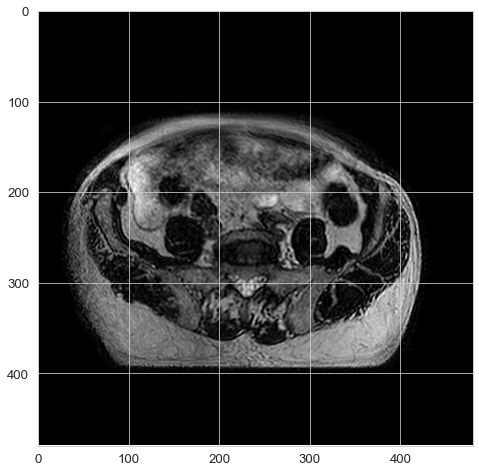

In [41]:
# viusualise masks
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

# nifti masks
image = sitk.GetArrayFromImage(sitk.ReadImage("C:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\Data\\DiceTest\\0001464_MR1_Raw.nii"))
print(image.shape, image.dtype)
m1 = sitk.GetArrayFromImage(sitk.ReadImage("C:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\Data\\DiceTest\\0001464_MR1_Prostate_RP.nii"))
print(m1.shape, m1.dtype)
# plot image
plt.figure(figsize=(12, 8))
plt.imshow(image[0], cmap="gray")
plt.imshow(m1, alpha=0.5, cmap="Reds")
# remove gridlines and ticks
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()